# GPU 설정

In [ ]:
## GPU 사용시, GPU를 먼저 선택 후, 아래 코드(구글 드라이브 마운팅) 실행해야함!!!
# # 초기 1회 실행
from google.colab import drive
drive.mount('/content/drive')
# 코드 실행

Mounted at /content/drive


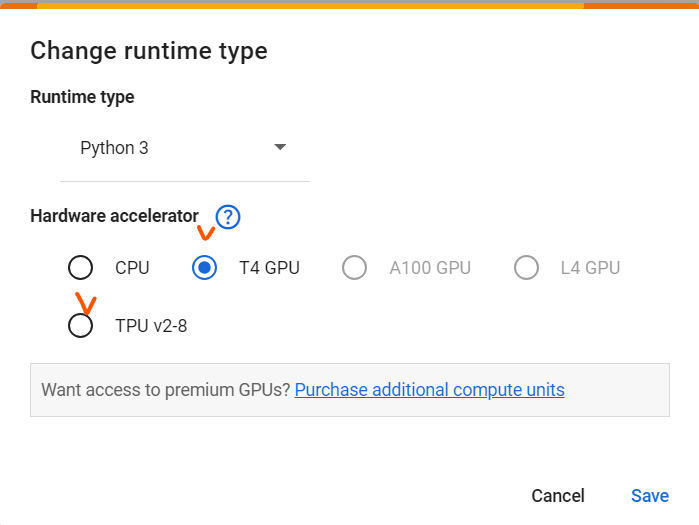

In [ ]:
import torch
## Google Colab에서 GPU 사용 설정, gpu가 있으면 gpu 사용, 아니면 cpu  사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# import torch

# 사용 가능한 GPU가 몇 개인지 확인
gpu_count = torch.cuda.device_count()

# 각 GPU에 대한 정보 출력
for i in range(gpu_count):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")
    print(f"총 멀티프로세서 수: {torch.cuda.get_device_capability(i)}")  # Compute Capability 확인
    print("멀티프로세서 =/= 코어수 ")

In [ ]:
# 초기 1회 실행
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
# install_and_import(['', ''])


In [ ]:
ppath = '/content/drive/MyDrive/aibootcamp/딥러닝/data'

In [ ]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## 데이터 읽기

In [ ]:
## 약간 느림..
train = pd.read_csv(ppath + '/mnist_train.csv')
test = pd.read_csv(ppath + '/mnist_test.csv')

In [ ]:
train.shape, test.shape

((60000, 785), (10000, 785))

In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [ ]:
X_train, y_train = train.drop('label', axis=1), train['label']
X_test, y_test = test.drop('label', axis=1), test['label']

### 데이터 확인

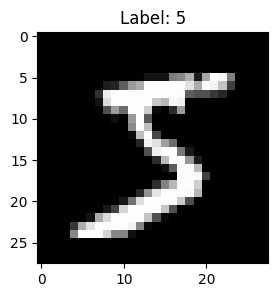

In [ ]:
## 첫 번째 이미지 확인
idx = 0
plt.figure(figsize=(3, 3))
plt.imshow(X_train.loc[idx].to_numpy().reshape(28, 28),
                        cmap = 'gray' # 실제로는 그레이 스케일
                        )
plt.title("Label: " + str(train.label[idx].item()))
plt.show()

[47649 16569 28456  5583 12515]


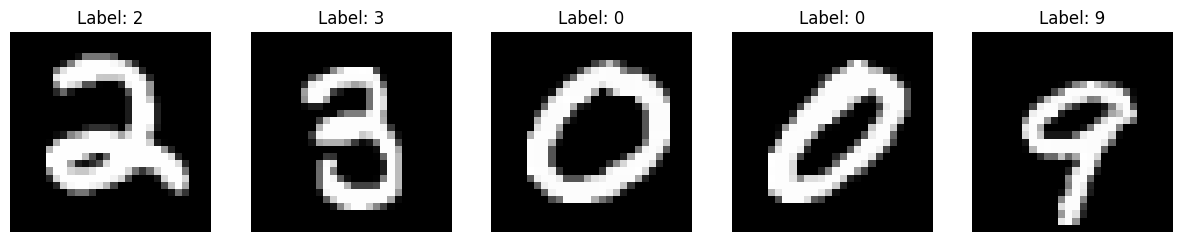

In [ ]:
## 여러 이미지 확인 (랜덤 5개)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
indices = np.random.choice(range(0, X_train.shape[0]),
                                                          size = 5,
                                                          replace=False)
print(indices)


for i, j in enumerate(indices):
    axes[i].imshow(X_train.loc[j].to_numpy().reshape(28, 28), cmap = 'gray')
    axes[i].set_title("Label: " + str(train.label[j].item()))
    axes[i].axis('off')
plt.show()

### 전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler

## MinMaxScaler 정의
normalizer = MinMaxScaler()

# 훈련 데이터 정규화
X_train_normalized = normalizer.fit_transform(X_train)

# 테스트 데이터 정규화
X_test_normalized = normalizer.transform(X_test)

## 사실 아래와 결과는 같음..
# X_train_normalized = X_train / 255.0
# X_test_normalized = X_test / 255.0

# Convolutional Neural Network

## 파이토치

- 재현을 위한 랜덤 시드 고정
  - 랜덤
  - 넘파이
  - 파이토치

In [ ]:
## 재현을 위한 랜덤 시드 고정...
import random
import numpy as np
import torch

## 랜덤 시드 고정 함수 정의
def set_seed(seed):
  ## 시드 고정
  random.seed(seed)                 # Python 기본 랜덤 시드 고정
  np.random.seed(seed)           # NumPy 랜덤 시드 고정
  torch.manual_seed(seed)     # PyTorch CPU 시드 고정

  ## GPU가 있는 경우 시드 고정, GPU 연산에서 사용되는 난수 생성기의 시드를 고정
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 시드 고정

  ## CuDNN 설정 (GPU 사용 시), CuDNN 라이브러리의 비결정적 연산을 방지,  동일한 결과를 얻기 위한 설정..
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


## 시드 고정
set_seed(123)  # 원하는 시드 값 설정


### 파이토치 데이터 형식으로 변환
- df, np.array to Tensor 형태

In [ ]:
## 파이토치 데이터셋으로 변환
X_train_tensor = torch.tensor(X_train_normalized, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.long)

X_test_tensor = torch.tensor(X_test_normalized, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.long)

In [ ]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [ ]:
## 차원 변경!! 중요
# 현재 X_train_tensor.shape가 torch.Size([60000, 784])
# 각 28x28 크기의 2D 이미지에서 1D 벡터(784차원)로 변환된 상태임
# 하지만, Conv2D 레이어는 이미지의 2D 형식을 유지해야 하므로,
# 이를 다시 28x28의 이미지 형태인 4차원 텐서 (배치(데이터) 크기, 채널 수, 높이, 너비) 로 변환해줘야함......

## (배치 크기, 채널 수, 높이, 너비)로 변환
X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)  # -1은 "나머지 알아서",  흑백이라 채널이 1
X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)

## 변환된 크기 확인
print(X_train_tensor.shape)  # torch.Size([60000, 1, 28, 28])
print(X_test_tensor.shape)    # torch.Size([10000, 1, 28, 28])

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


### 모델 정의

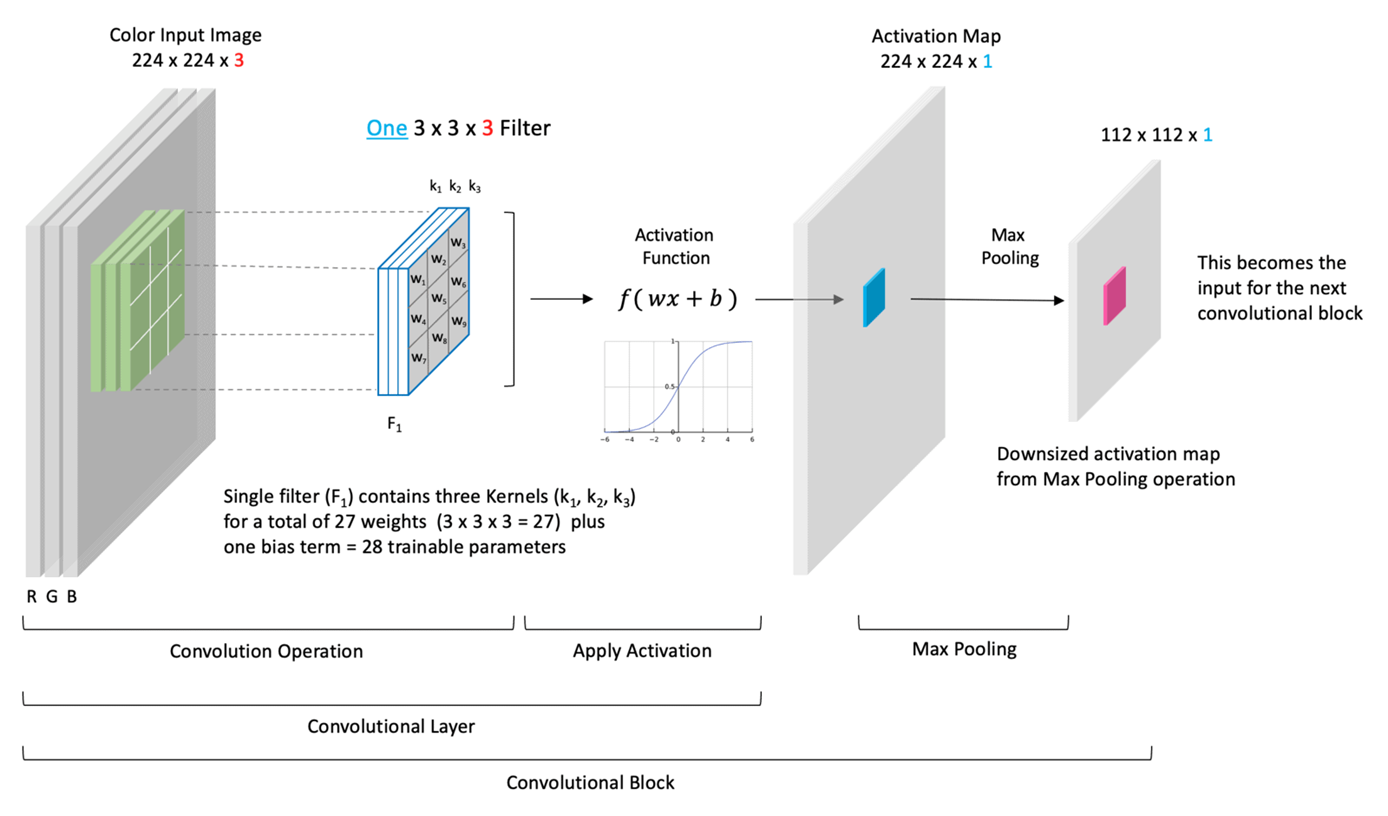

In [ ]:
class CNN(nn.Module):    # nn.Module: 파이토치의 기능을 상속받음
    def __init__(self,    ):                                  # 클래스 초기 설정
        super(CNN, self).__init__()  # 클래스 기능 초기화 및 기능 불러오기

        # Convolutional Layer 1: 흑백 이미지이므로 input channel은 1, 필터 16개로 설정
        self.conv1 = nn.Conv2d(in_channels = 1,      # 흑백 이미지라 1, 컬러면 3
                                                        out_channels = 16,  # filter의 개수 (커널의 개수)
                                                        kernel_size = 3,
                                                        stride = 1,
                                                        padding = 1)
        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size = 2,
                                                              stride = 2)
        # Average Pooling
        # self.pool = nn.AvgPool2d(kernel_size = 2,
        #                                                       stride = 2)

        # Convolutional Layer 2: 필터 32개
        self.conv2 = nn.Conv2d(in_channels = 16,       # 첫번째 conv1 레이어의 out_channels의 크기와 동일
                                                          out_channels = 32,   # filter의 개수 (커널의 개수)
                                                          kernel_size = 3,
                                                          stride = 1,
                                                          padding = 1)

        # Fully Connected Layer
        self.fc1 = nn.Linear(in_features = 32 * (7 * 7), # 28x28이 MaxPooling을 두 번 거쳐 7x7로 축소됨
                                                out_features = 128)        #사용자가 선택
        self.fc2 = nn.Linear(in_features = 128,           # fc1 의 out_features와 동일한 크기
                                                out_features = 10)          # 10개의 출력 클래스 (0~9 숫자)

    def forward(self, x):   # 모델의 구조(순서)를 결정

        # Convolution 1 -> ReLU -> Pooling
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Convolution 2 -> ReLU -> Pooling
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 32 * 7 * 7)
        # Fully Connected 1 -> ReLU
        x = self.fc1(x)
        x = torch.relu(x)
        # Fully Connected 2 -> 예측 확률
        x = self.fc2(x)

        # softmax함수는 CrossEntrophyLoss 에서는 생략 가능

        return x

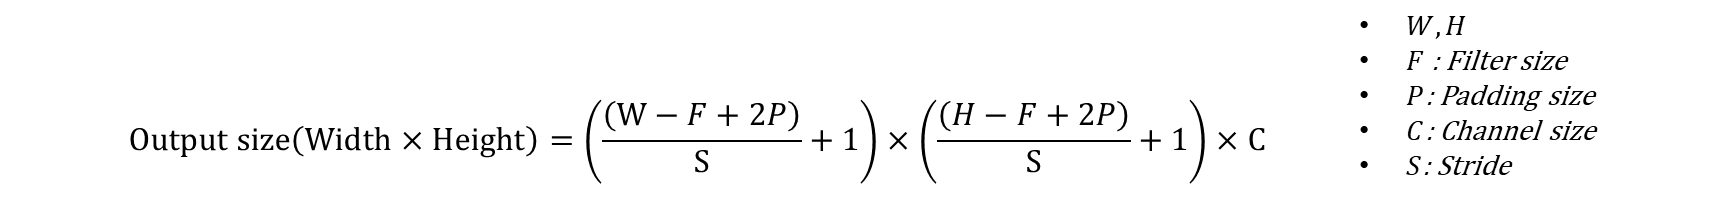

출력 크기 계산

   - 첫 번째 Convolution Layer
    - 입력 이미지 크기 = 28X28
    - 필터 크기 = 3 X 3
    - 패딩 = 1
    - 스트라이드 = 1

  - $\
\text{Output size} = \frac{28 - 3 + 2(1)}{1} + 1 = 28 \times 28
$

- Max Pooling
  - $\text{Pooling 후 이미지 크기} = \frac{28}{2} \times \frac{28}{2} = 14 \times 14
$

- 두 번째 Convolution Layer
    - 입력 이미지 크기 = 14X14
    - 필터 크기 = 3 X 3
    - 패딩 = 1
    - 스트라이드 = 1
  - $\text{Output size} = \frac{14 - 3 + 2(1)}{1} + 1 = 14 \times 14$
  
- Max Pooling 후
  - $\
\frac{14}{2} \times \frac{14}{2} = 7 \times 7
\$


### 모델 초기화

In [ ]:
## 모델 초기화
model = CNN().to(device)  # 모델을 GPU로 이동
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### 모델 구조 확인

In [ ]:
from torchsummary import summary

## 모델 구조 요약 출력 (입력 크기: 1채널, 28x28 이미지)
summary(model, input_size  = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                  [-1, 128]         200,832
            Linear-6                   [-1, 10]           1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.79
Estimated Total Size (MB): 0.97
----------------------------------------------------------------


In [ ]:
# 현재 모델 저장후, https://netron.app/ 접속하여, accept, upload 후 확인

## 현재 모델 저장
torch.save(model,  ppath + "/model.pth")

### 트레이닝 함수 정의

In [ ]:
from torch.utils.data import DataLoader

## 학습 함수 정의
def train_model(model: nn.Module,
                                  train_loader: DataLoader,
                                  criterion: nn.Module,
                                  optimizer: optim.Optimizer,
                                  num_epochs: int):

    model.train()  # 학습 모드로 전환
    epoch_losses = []  # 에폭별 손실 저장 리스트
    running_loss = 0.0  # 에폭 동안의 누적 손실 초기화

    for epoch in range(num_epochs):
        running_loss = 0.0  # 에폭별 손실 초기화
        for images, labels in train_loader:

            # 데이터를 GPU로 전송 (GPU 사용 시)
            images, labels = images.to(device), labels.to(device)

            # 모델 예측
            outputs = model(images)

            # 손실 계산
            loss = criterion(outputs, labels)

           # 역전파
            optimizer.zero_grad()  # 기존 그래디언트 초기화 (위치는 순전파 이후! 역전파 이전!  손실을 계산한 후, 손실의 기울기를 계산하기 전에 기존의 그래디언트를 초기화..)
            loss.backward()              # 역전파 수행 (자동 미분)
            optimizer.step()              # 가중치 업데이트

            # 현재 배치의 손실 합산
            running_loss += loss.item()

        # 에폭 종료 후 평균 손실 계산 및 저장
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return epoch_losses, model


### 가중치 초기화

In [ ]:
import torch.nn.init as init

## He 초기화 함수 정의
# relu 계열, 딥러닝에 더 적합
def initialize_weights_he(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, nonlinearity = 'relu')  # He 초기화 (uniform 분포)
        if m.bias is not None:
            init.zeros_(m.bias)                                                                       # 편향은 0으로 초기화

## 순서는 모델 초기화 -> 가중치 초기화 -> 옵티마이져 초기화 !!!!!
model.apply(initialize_weights_he)  # 가중치 초기화

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### 손실 함수와 옵티마이저 정의


In [ ]:
## 손실 함수
criterion = nn.CrossEntropyLoss()

## 옵티마이저
## adam > = Nadam(adam의 약간 개선 버전) == adadelta(메모리 문제있으면)
optimizer = optim.Adam(
        model.parameters(),      # 모델의 학습 가능한 파라미터 전달
        lr = 0.01,                               # learning rate, 파라미터 업데이트의 크기를 결정, 기본값은 0.001
        weight_decay = 0,           # 가중치 감쇠 (L2 규제, weight decay), 기본값은 0
        amsgrad = False               # AMSGrad 알고리즘(adam 개선 버전..)을 사용할지 여부, 기본값은 False
)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

### 데이터 로더
- 데이터를 미니 배치 단위로 나누어 모델에 공급(feed) 하는 방법
- 셔플, 병렬 처리 등을 지원하며, 학습 속도를 최적화할때 필요
- 배치크기 정하기..
  - 보통 2의 승수로 선택 64, 128, 1024 등
  - 왕도가 없음..

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

## TensorDataset 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [ ]:
## 데이터로더 생성
# train data 로더
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                                                                          batch_size = 512,
                                                                                          shuffle = True,
                                                                                          pin_memory = True, #  GPU 사용시 속도를 높이기 위한 옵션
                                                                                          num_workers = 6) # 멀티쓰레딩, CPU 코어개수.. '-1'은 오류..주의
# test data 로더
# 데이터 양이 많으면, 더 효율적..
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                                                                      batch_size = 512,
                                                                                      shuffle = True,
                                                                                      pin_memory = True, #  GPU 사용시 속도를 높이기 위한 옵션
                                                                                      num_workers = 6) # 멀티쓰레딩, CPU 코어개수.. '-1'은 오류..주의


In [ ]:
## 첫 번째 배치의 데이터 확인
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break


torch.Size([512, 1, 28, 28]) torch.Size([512])


In [ ]:
## CPU 코어 개수 출력
cpu_cores = os.cpu_count()
cpu_cores

96

### 모델 학습
- 중요 순서는 __모델 초기화 -> 가중치 초기화 -> 옵티마이져 초기화__

In [ ]:
## 모델 학습...  오래 걸림..
num_epochs = 20

## 재학습시에는 모델 + 옵치마이져 초기화 를 꼭 해줘야 함!!!!
# model = CNN().to(device)
# optimizer = optim.Adam(
#         model.parameters(),      # 모델의 학습 가능한 파라미터 전달
#         lr = 0.01,                               # learning rate, 파라미터 업데이트의 크기를 결정, 기본값은 0.001
#         weight_decay = 0,           # 가중치 감쇠 (L2 규제, weight decay), 기본값은 0
#         amsgrad = False               # AMSGrad 알고리즘을 사용할지 여부, 기본값은 False
# )
## 그렇지 않으면 이전 학습에서 이미 학습한 가중치를 기반으로 계속 업데이트하게됨...이상한 결과가 나올 수 있다..

set_seed(123)

loss_history, trained_model = train_model(model = model,
                                                                                          train_loader = train_loader,
                                                                                          criterion = criterion,
                                                                                          optimizer = optimizer,
                                                                                          num_epochs = num_epochs)
loss_history, trained_model # 만약 AssertionError: can only test a child process 발생시 num_workers = 0으로 변경

Epoch [1/20], Loss: 0.2578
Epoch [2/20], Loss: 0.0533
Epoch [3/20], Loss: 0.0387
Epoch [4/20], Loss: 0.0305
Epoch [5/20], Loss: 0.0238
Epoch [6/20], Loss: 0.0234
Epoch [7/20], Loss: 0.0192
Epoch [8/20], Loss: 0.0109
Epoch [9/20], Loss: 0.0133
Epoch [10/20], Loss: 0.0099
Epoch [11/20], Loss: 0.0136
Epoch [12/20], Loss: 0.0107
Epoch [13/20], Loss: 0.0087
Epoch [14/20], Loss: 0.0119
Epoch [15/20], Loss: 0.0147
Epoch [16/20], Loss: 0.0099
Epoch [17/20], Loss: 0.0103
Epoch [18/20], Loss: 0.0133
Epoch [19/20], Loss: 0.0115
Epoch [20/20], Loss: 0.0087


([0.25780576327026394,
  0.053328489071800045,
  0.038711640506319825,
  0.030535946008196826,
  0.023785417502888054,
  0.023370906971079315,
  0.019164342224061236,
  0.010932534604562226,
  0.013339730822165512,
  0.009916211368902823,
  0.013551474446272952,
  0.010740641117297207,
  0.008656918999326605,
  0.011906894394966096,
  0.014654057775229469,
  0.009901499905982608,
  0.010269943686395536,
  0.013297641140186096,
  0.011486980666493271,
  0.008682173479274306],
 CNN(
   (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (fc1): Linear(in_features=1568, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=10, bias=True)
 ))

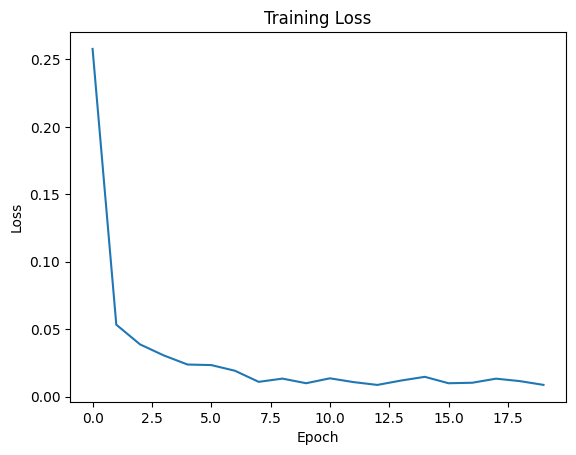

In [ ]:
## 에폭~Loss 그래프 그리기
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 테스트데이터에 적용

In [ ]:
from sklearn.metrics import accuracy_score

## 평가 모드로 전환
trained_model.eval()

## 그레디언트 비활성화 후 모델 평가
all_preds = []
all_labels = []

with torch.no_grad():  # 그레디언트 계산 비활성화
    for X_batch, y_batch in test_loader:  # test_loader를 사용하여 배치 단위로 처리
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # 모델 예측
        y_pred = trained_model(X_batch)

        # 예측 값 -> 클래스 값으로 변환 (0.5 기준으로)
        #  y_pred_class = (y_pred > 0.5).float()

        # 다중 클래스 예측 값을 클래스 레이블로 변환 (Softmax 적용 후 argmax 사용) !!
        y_pred_class = torch.argmax(y_pred, dim = 1)

        # 배치의 예측 결과 저장
        all_preds.append(y_pred_class.cpu())
        all_labels.append(y_batch.cpu())

## 예측 값과 실제 값을 연결
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

## 정확도 계산
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

## 혼동 행렬 및 분류 보고서 출력
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, digits=4))


Test Accuracy: 0.9879

Classification Report:
              precision    recall  f1-score   support

           0     0.9939    0.9959    0.9949       980
           1     0.9895    0.9938    0.9916      1135
           2     0.9892    0.9777    0.9834      1032
           3     0.9872    0.9960    0.9916      1010
           4     0.9908    0.9847    0.9877       982
           5     0.9822    0.9922    0.9872       892
           6     0.9906    0.9885    0.9896       958
           7     0.9789    0.9922    0.9855      1028
           8     0.9856    0.9836    0.9846       974
           9     0.9909    0.9742    0.9825      1009

    accuracy                         0.9879     10000
   macro avg     0.9879    0.9879    0.9879     10000
weighted avg     0.9879    0.9879    0.9879     10000



- 간단 해석..
   - 전체 정확도, 평균값
   - 각 클래스 별로 f1 score 계산됨



## 참고


###  파라미터 갯수 , 가중치 출력하기

In [ ]:
## 파라미터 개수를 계산하는 함수 정의
def count_parameters(model):
    # 모델의 학습 가능한 파라미터 중, 각각의 파라미터의 요소 개수를 모두 더하기
    params = [param.numel() for param in model.parameters() if param.requires_grad]
    output = sum(params)

    return output

## 모델의 총 학습 가능한 파라미터 수를 계산하여 출력
total_params = count_parameters(trained_model)
print('Total parameters:' , total_params )

Total parameters: 206922


In [ ]:
## 모델의 가중치와 편향을 출력하고, 각 레이어별 파라미터 정보를 출력하는 코드
for name, params in trained_model.named_parameters(): # 모델의 모든 파라미터를 이름과 함께 반환..

    if params.requires_grad:  # 파라미터가 학습 가능한 경우 (requires_grad=True)
        # 레이어 이름, 파라미터의 크기(모양), 파라미터 값 일부를 출력
        print(f'Layer: {name} \n | Size: {params.size()} \n | Values : {params[:2]}\n')


Layer: conv1.weight 
 | Size: torch.Size([16, 1, 3, 3]) 
 | Values : tensor([[[[-0.4751,  0.5125, -0.0143],
          [-1.0242, -0.0280,  0.4104],
          [-0.2066, -0.8928, -0.7044]]],


        [[[ 0.3522,  0.1614,  0.2251],
          [-0.3553,  0.0306,  0.3498],
          [-0.9441, -0.1869,  0.5546]]]], grad_fn=<SliceBackward0>)

Layer: conv1.bias 
 | Size: torch.Size([16]) 
 | Values : tensor([-0.1699, -0.3356], grad_fn=<SliceBackward0>)

Layer: conv2.weight 
 | Size: torch.Size([32, 16, 3, 3]) 
 | Values : tensor([[[[-0.0305,  0.0331, -0.1035],
          [ 0.0093,  0.0122,  0.0099],
          [-0.0417,  0.0200, -0.0064]],

         [[-0.0350, -0.0576, -0.0139],
          [-0.0784, -0.0400, -0.0089],
          [-0.1033, -0.0883,  0.0522]],

         [[ 0.0169, -0.0462, -0.0574],
          [-0.0545, -0.0080, -0.1201],
          [-0.1378, -0.0981, -0.0892]],

         [[-0.0053,  0.0016, -0.1411],
          [-0.1417, -0.1379, -0.0248],
          [-0.0132, -0.1445, -0.0987]],

     

### 중간 레이어 feature map 시각화

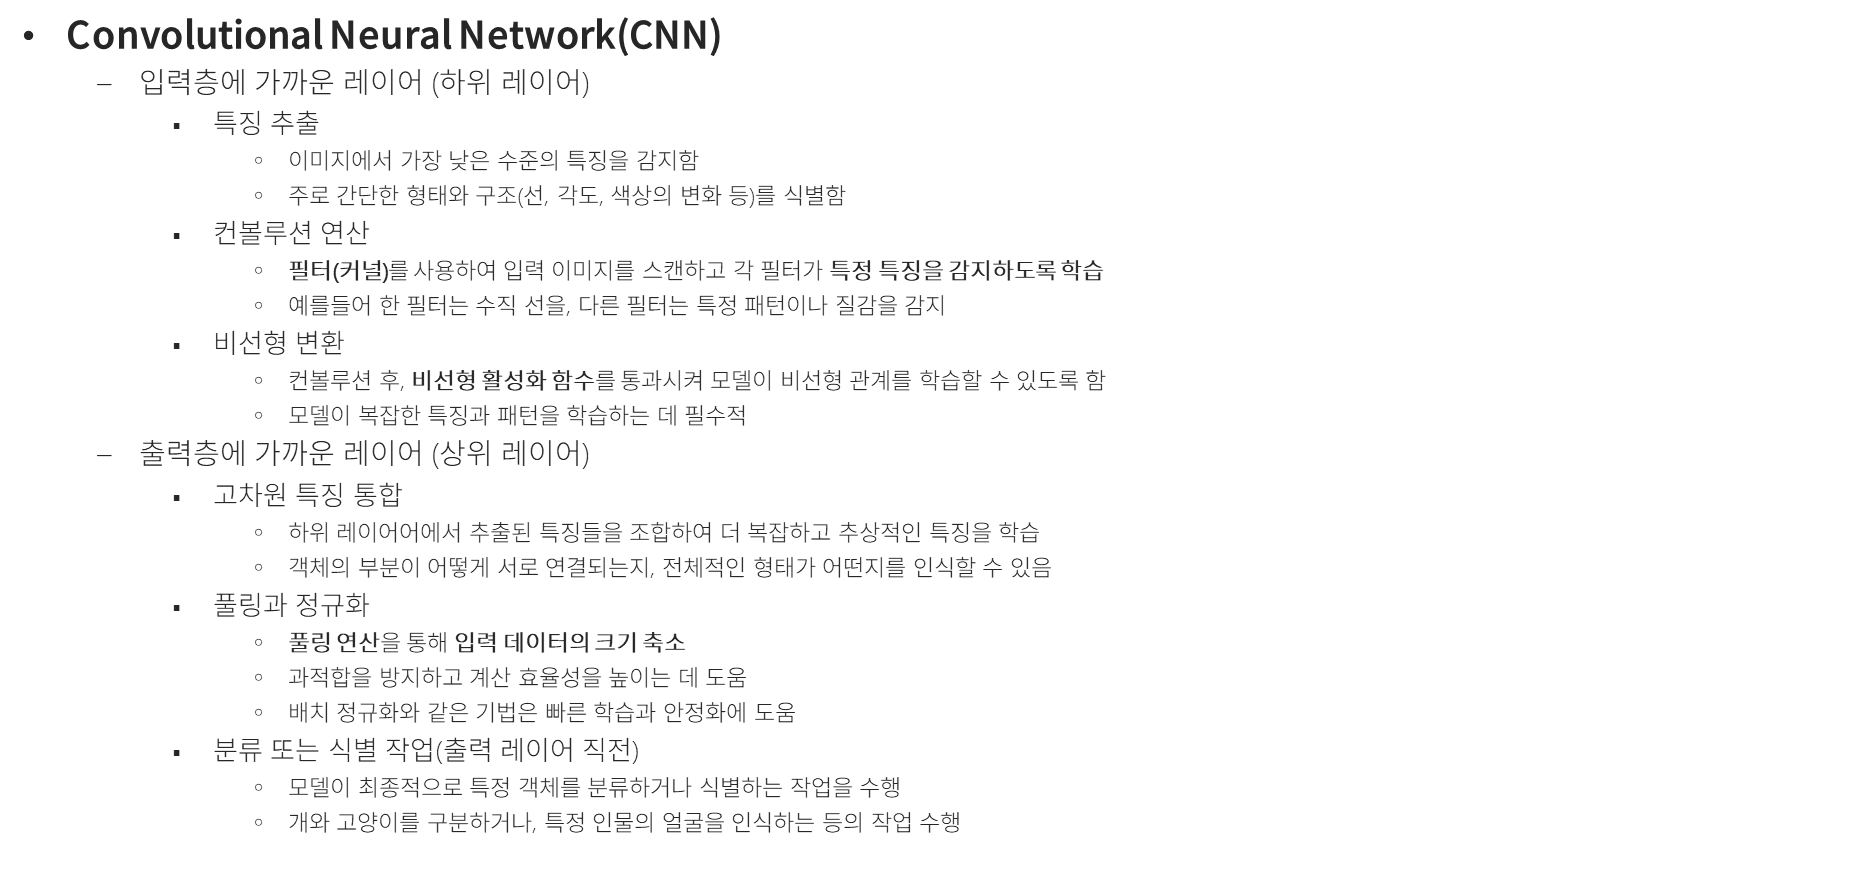

In [ ]:
## 시드 설정
set_seed(123)

## test_loader에서 배치 단위로 테스트 이미지 로드
images, _ = next(iter(test_loader))          # 첫 번째 배치의 이미지 가져오기
images = images.to(device)                        # 이미지를 GPU로 이동

In [ ]:
trained_model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

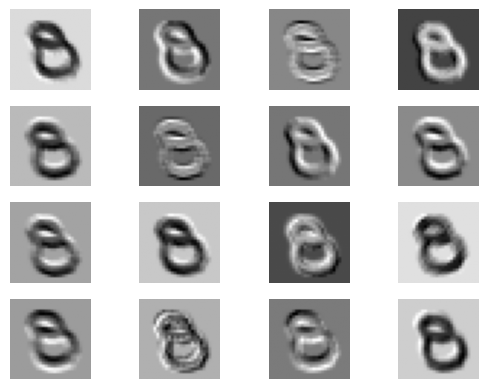

In [ ]:
 ## 첫 번째 Convolutional Layer의 Feature Map 시각화

trained_model.eval()
with torch.no_grad():

    feature_maps_conv1 = trained_model.conv1(images)                                                  # Conv1 레이어를 통과한 결과
    feature_maps_conv1 = feature_maps_conv1.cpu().detach().numpy()  # GPU에서 CPU로 이동하고, numpy로 변환

    for i in range(16):              # 첫 16개의 feature map 시각화
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps_conv1[0, i, :, :],  # batch_size, num_filters, height, width
                                  cmap = 'gray'
                                )
        plt.axis('off') # 축 표시 제거
    plt.show()


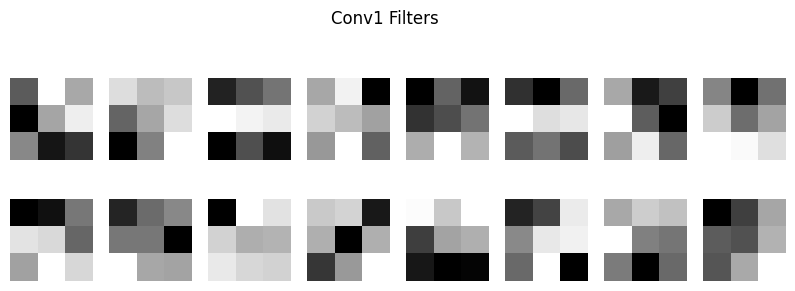

In [ ]:
## Conv1 레이어의 필터(가중치) 시각화

trained_model.eval()
with torch.no_grad():
    # Conv1 레이어의 필터(가중치) 추출
    conv1_weights = trained_model.conv1.weight.cpu().detach().numpy()  # Conv1의 필터 값을 numpy로 변환

    # 필터 시각화 (필터가 1채널일 경우)
    plt.figure(figsize=(10, 6))
    num_filters = conv1_weights.shape[0]  # 필터 개수

    # 필터가 흑백 이미지(1채널)이므로 각 필터를 이미지로 시각화
    for i in range(num_filters):  # 필터 개수만큼 반복
        plt.subplot(4, 8, i + 1)
        plt.imshow(conv1_weights[i, 0, :, :], cmap='gray')  # 필터의 첫 번째 채널을 시각화
        plt.axis('off')  # 축 표시 제거
    plt.suptitle("Conv1 Filters")
    plt.show()


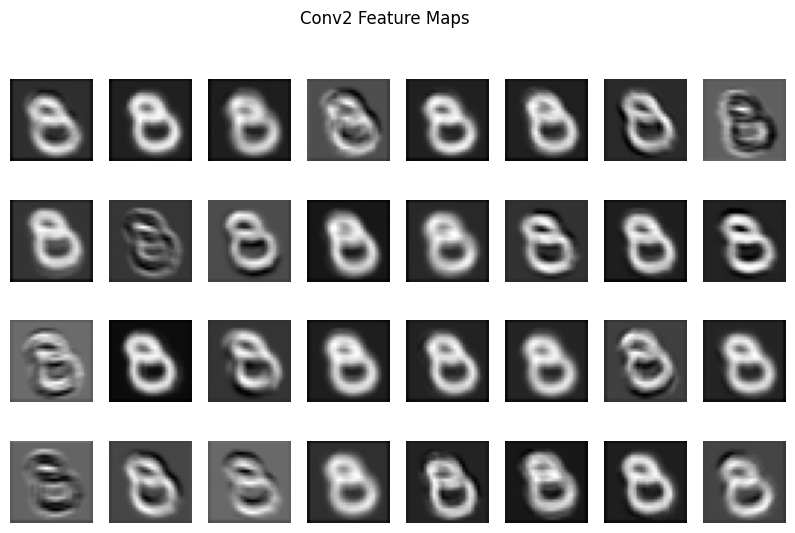

In [ ]:
 ## 두 번째 Convolutional Layer의 Feature Map 시각화

trained_model.eval()
with torch.no_grad():

    feature_maps_conv1 = trained_model.conv1(images)                                                  # Conv1 레이어를 통과한 결과
    feature_maps_conv1 = feature_maps_conv1.cpu().detach().numpy()  # GPU에서 CPU로 이동하고, numpy로 변환

    # Conv2 레이어를 통해 Conv1의 출력 통과 (Conv2의 feature map 계산)
    feature_maps_conv2 = torch.tensor(feature_maps_conv1).to(device) #  Conv1 레이어의 출력을 GPU로 이동 (텐서로 변환)
    feature_maps_conv2 = trained_model.conv2(feature_maps_conv2)                      #  Conv2 레이어를 통해 Conv1의 출력을 통과시켜 Conv2의 feature map 계산
    feature_maps_conv2 = feature_maps_conv2.cpu().detach().numpy()  # GPU에서 CPU로 이동하고, numpy로 변환

    # 32개의 conv2 feature map을 시각화
    plt.figure(figsize=(10, 6))
    for i in range(32):              # 32개의 필터에 해당하는 feature map만 시각화
        plt.subplot(4, 8, i + 1)
        plt.imshow(feature_maps_conv2[0, i, :, :], cmap = 'gray')  # 첫 번째 이미지의 i번째 feature map 시각화
        plt.axis('off')  # 축 표시 제거
    plt.suptitle("Conv2 Feature Maps")
    plt.show()  # Conv2 그림 출력



- 레이어 수준별 특징..
  - 하위 레이어: 저수준 특징(모서리, 경계선, 대비, 텍스처 등 )을 학습하며, 원래 이미지와 매우 유사
  - 중간 레이어: 중간 수준 특징을 학습하면서, 저수준 특징을 결합해 조금 더 복잡한 패턴을 학습
  - 상위 레이어: 고차원 특징을 학습하여, 추상적이고 의미론적인 정보를 추출, 구체적인 세부 정보보다는 이미지의 전반적인 의미를 추출..


-https://medium.com/@saba99/feature-map-35ba7e6c689e

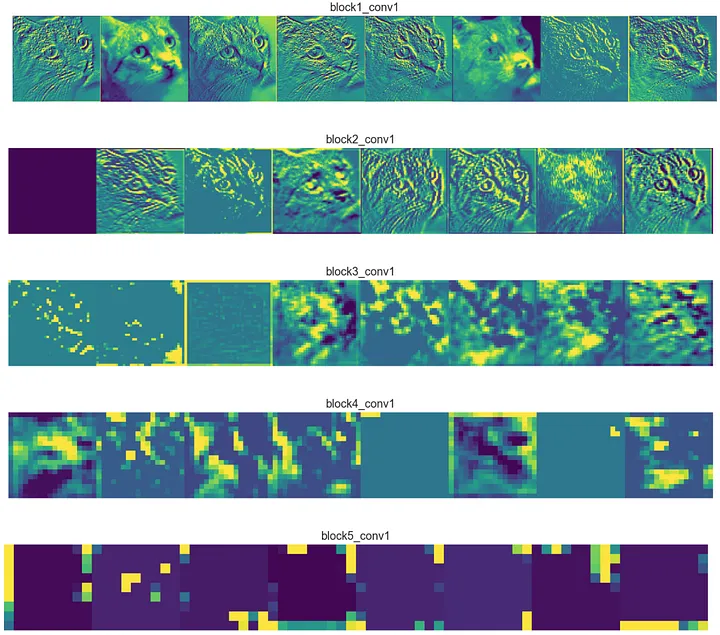

In [ ]:
## Flatten Layer의 출력 확인

trained_model.eval()
with torch.no_grad():

    # Conv1 레이어 통과
    feature_maps_conv1 = trained_model.conv1(images)  # Conv1 레이어를 통과한 결과
    feature_maps_conv1 = feature_maps_conv1.to(device)  # GPU에서 처리

    # Conv2 레이어 통과 (Conv2 feature map 계산)
    feature_maps_conv2 = trained_model.conv2(feature_maps_conv1)  # Conv2 레이어를 통해 Conv1의 출력 통과
    feature_maps_conv2 = feature_maps_conv2.cpu().detach().numpy()  # GPU에서 CPU로 이동하고, numpy로 변환


    # Flatten Layer 출력 확인 (Conv2 feature map을 Flatten)
    feature_maps_conv2 = trained_model.conv2(feature_maps_conv1)  # Conv2 레이어를 다시 통과시킴 (GPU에서 처리 중)

    # Flatten Layer 적용
    flatten_output = feature_maps_conv2.view(feature_maps_conv2.size(0), -1)  # Flatten 적용
    flatten_output = flatten_output.cpu().detach().numpy()  # Numpy로 변환

    # Flatten된 값 출력 (첫 번째 이미지에 대해)
    print("Flatten Layer Output (첫 번째 이미지):")
    print(flatten_output[0])  # 첫 번째 이미지의 Flatten 된 벡터 값 출력


Flatten Layer Output (첫 번째 이미지):
[0.51526666 0.9188269  0.9188269  ... 0.82280236 0.82280236 0.16502912]


In [ ]:
flatten_output.shape

(512, 25088)

## 하이퍼파라미터 최적화

#### 랜덤서치

- 랜덤 서치1
  - GridSearchCV보다 효율적
  - 더 넓은 파라미터 공간을 탐색 할 수 있어서, 최적값을 찾을 확률이 다소 더 높음..

In [ ]:
## 오래 걸림....
import random

## 평가 함수
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # 데이터를 GPU로 옮기기 (device로 이동)
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # 모델 예측
        y_pred = model(X_test)

        # 다중 클래스 예측 값을 클래스 레이블로 변환 (Softmax 적용 후 argmax 사용) !!
        y_pred_class = torch.argmax(y_pred, dim=1)
        accuracy = accuracy_score(y_test.cpu().numpy(), y_pred_class.cpu().numpy())
    return accuracy


## 랜덤 하이퍼파라미터 생성 함수
def get_random_hyperparameters():
    return {
        'learning_rate': random.choice([0.001, 0.01, 0.1]),
        'batch_size': random.choice([128, 512, 4048]),
        'epochs': random.choice([10, 20, 30])
    }

## 랜덤 서치 하이퍼파라미터 튜닝
n_iter = 20  # 랜덤 서치 반복 횟수
best_accuracy = 0
best_params = {}
best_model = None

for _ in range(n_iter):
    # 랜덤 하이퍼파라미터 선택
    params = get_random_hyperparameters()

    print("params:")
    print(params)
    # 모델 초기화
    model = CNN().to(device)

    # 가중치 초기화
    model.apply(initialize_weights_he)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                                                        lr = params['learning_rate'])

    ## 데이터 로더 생성
    train_dataset = TensorDataset(X_train_tensor,  y_train_tensor)


    ## 데이터로더 생성
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                                                                             batch_size = params['batch_size'],
                                                                                             shuffle = True,
                                                                                             pin_memory = True, #  GPU 사용시 속도를 높이기 위한 옵션
                                                                                             num_workers = 0) # 멀티쓰레딩, CPU 코어개수.. '-1'은 오류..주의

    ## 모델 훈련
    loss_history, trained_model = train_model(model,
                                                                                              train_loader,
                                                                                              criterion,
                                                                                              optimizer,
                                                                                              params['epochs'])

    ## 모델 평가
    accuracy = evaluate_model(trained_model, X_test_tensor, y_test_tensor)
    print("accuracy:", accuracy, "\n")


    ## 최고 성능 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = model


Epoch [1/10], Loss: 0.5229
Epoch [2/10], Loss: 0.1338
Epoch [3/10], Loss: 0.0839
Epoch [4/10], Loss: 0.0643
Epoch [5/10], Loss: 0.0539
Epoch [6/10], Loss: 0.0453
Epoch [7/10], Loss: 0.0398
Epoch [8/10], Loss: 0.0345
Epoch [9/10], Loss: 0.0309
Epoch [10/10], Loss: 0.0277
accuracy: 0.9878 

Epoch [1/10], Loss: 0.4076
Epoch [2/10], Loss: 0.0880
Epoch [3/10], Loss: 0.0615
Epoch [4/10], Loss: 0.0481
Epoch [5/10], Loss: 0.0417
Epoch [6/10], Loss: 0.0343
Epoch [7/10], Loss: 0.0289
Epoch [8/10], Loss: 0.0287
Epoch [9/10], Loss: 0.0234
Epoch [10/10], Loss: 0.0264
accuracy: 0.9869 

Epoch [1/30], Loss: 0.6540
Epoch [2/30], Loss: 0.1405
Epoch [3/30], Loss: 0.0840
Epoch [4/30], Loss: 0.0657
Epoch [5/30], Loss: 0.0534
Epoch [6/30], Loss: 0.0453
Epoch [7/30], Loss: 0.0400
Epoch [8/30], Loss: 0.0362
Epoch [9/30], Loss: 0.0339
Epoch [10/30], Loss: 0.0272
Epoch [11/30], Loss: 0.0253
Epoch [12/30], Loss: 0.0226
Epoch [13/30], Loss: 0.0199
Epoch [14/30], Loss: 0.0186
Epoch [15/30], Loss: 0.0162
Epoch [16

In [ ]:
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)
print("Best model:", best_model)

Best parameters: {'learning_rate': 0.001, 'batch_size': 512, 'epochs': 30}
Best accuracy: 0.9909
Best model: CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


- 랜덤서치2
  - 랜덤 서치 1 +  CV...

In [ ]:
## 아주아주 오래 걸림....
from sklearn.model_selection import KFold

## 평가 함수 (랜덤서치1과 동일)
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # 데이터를 GPU로 옮기기 (device로 이동)
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # 모델 예측
        y_pred = model(X_test)

        # 다중 클래스 예측 값을 클래스 레이블로 변환 (Softmax 적용 후 argmax 사용) !!
        y_pred_class = torch.argmax(y_pred, dim=1)
        accuracy = accuracy_score(y_test.cpu().numpy(), y_pred_class.cpu().numpy())
    return accuracy


## 랜덤 하이퍼파라미터 생성 함수 (랜덤서치1과 동일)
def get_random_hyperparameters():
    return {
        'learning_rate': random.choice([0.001, 0.01, 0.1]),
        'batch_size': random.choice([128, 512, 4048]),
        'epochs': random.choice([10, 20, 30])
    }


## 교차검증을 적용한 하이퍼파라미터 튜닝
n_iter = 20  # 랜덤 서치 횟수
best_accuracy = 0
best_params = {}
best_model = None

## KFold 교차검증 설정 (CV = 3)
kf = KFold(n_splits = 3, shuffle = True, random_state = 123)

for _ in range(n_iter):
    # 랜덤 하이퍼파라미터 선택
    params = get_random_hyperparameters()

    fold_accuracies = []

    # KFold로 데이터를 나눠서 교차검증 진행
    for train_index, val_index in kf.split(X_train_tensor):
        X_train_fold, X_val_fold = X_train_tensor[train_index], X_train_tensor[val_index]
        y_train_fold, y_val_fold = y_train_tensor[train_index], y_train_tensor[val_index]

        # 랜덤 하이퍼파라미터 선택
        params = get_random_hyperparameters()
        print("params:")
        print(params)

        # 모델 초기화
        model = CNN().to(device)

        # 가중치 초기화
        model.apply(initialize_weights_he)

        # 손실 함수와 옵티마이저 정의
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(),
                                                            lr = params['learning_rate'])

        ## 데이터 로더 생성
        train_dataset = TensorDataset(X_train_fold,  y_train_fold)


        ## 데이터로더 생성
        train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                                                                                batch_size = params['batch_size'],
                                                                                                shuffle = True,
                                                                                                pin_memory = True, #  GPU 사용시 속도를 높이기 위한 옵션
                                                                                                num_workers = 0) # 멀티쓰레딩, CPU 코어개수.. '-1'은 오류..주의




        # 모델 훈련
        loss_history, trained_model = train_model(model,
                                                                                                  train_loader,
                                                                                                  criterion,
                                                                                                  optimizer,
                                                                                                  params['epochs'])

        # 모델 평가
        accuracy = evaluate_model(trained_model, X_val_fold, y_val_fold)
        fold_accuracies.append(accuracy)

        print(f"accuracy: {accuracy}")


    # 폴드별 평균 정확도 계산
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Mean accuracy for current iteration: {mean_accuracy}")
    print(" ")
    print(" ")
    # 최고 성능 모델 저장
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = params
        best_model = model

params:
{'learning_rate': 0.1, 'batch_size': 4048, 'epochs': 20}
Epoch [1/20], Loss: 17.9591
Epoch [2/20], Loss: 2.3251
Epoch [3/20], Loss: 2.3076
Epoch [4/20], Loss: 2.3035
Epoch [5/20], Loss: 2.3022
Epoch [6/20], Loss: 2.3015
Epoch [7/20], Loss: 2.3016
Epoch [8/20], Loss: 2.3015
Epoch [9/20], Loss: 2.3016
Epoch [10/20], Loss: 2.3015
Epoch [11/20], Loss: 2.3015
Epoch [12/20], Loss: 2.3014
Epoch [13/20], Loss: 2.3019
Epoch [14/20], Loss: 2.3018
Epoch [15/20], Loss: 2.3017
Epoch [16/20], Loss: 2.3017
Epoch [17/20], Loss: 2.3014
Epoch [18/20], Loss: 2.3016
Epoch [19/20], Loss: 2.3017
Epoch [20/20], Loss: 2.3017
accuracy: 0.11015
params:
{'learning_rate': 0.1, 'batch_size': 4048, 'epochs': 30}
Epoch [1/30], Loss: 10.1217
Epoch [2/30], Loss: 2.3220
Epoch [3/30], Loss: 2.1986
Epoch [4/30], Loss: 1.5649
Epoch [5/30], Loss: 0.8575
Epoch [6/30], Loss: 0.5596
Epoch [7/30], Loss: 0.4352
Epoch [8/30], Loss: 0.3781
Epoch [9/30], Loss: 0.3387
Epoch [10/30], Loss: 0.3140
Epoch [11/30], Loss: 0.2915


In [ ]:
## 최적 하이퍼파라미터 출력
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)
print("Best model:", best_model)
## 사실 더 엄밀하게 한다면..Loss 부터 바꿔야...

Best parameters: {'learning_rate': 0.001, 'batch_size': 128, 'epochs': 20}
Best accuracy: 0.9847833333333335
Best model: CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### 최적화 모델의 결과 확인

In [ ]:
## 모델 Inference, (모델 평가라고 부르기도..)
best_model.eval() # 평가모드로 전환

## 그레디언트 계산 비 활성화 후 계산만..
with torch.no_grad(): # 특정 코드 블록의 실행 전후에 특별한 동작을 정의

    # 데이터를 device에 전달
    X_test_tensor = X_test_tensor.to(device)
    # y_test를 Tensor로 변환
    y_test_tensor = torch.tensor(y_test.values).to(device)

    # 모델 예측
    y_pred = best_model(X_test_tensor)

    # 다중 클래스 예측 값을 클래스 레이블로 변환 (Softmax 적용 후 argmax 사용) !!
    y_pred_class = torch.argmax(y_pred, dim=1)

    # 정확도 계산
    accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_pred_class.cpu().numpy())
    print(f'Test Accuracy: {accuracy:.4f}')



Test Accuracy: 0.9909


In [ ]:
# EOS

# 참고) 드롭아웃/배치정규화 효과 비교
- 배치 정규화: 학습 안정성 증가, 학습속도 증가가, 과적합 감소(조금)
- 드롭아웃: 과적합 감소, 학습 안정성(간접효과..)

In [ ]:
import torch
import torch.nn as nn

class CNN_dropout_batchNorm(nn.Module):                  # nn.Module: 파이토치의 기능을 상속받음
    def __init__(self, dropout_rate = 0.5):                              # 클래스 초기 설정
        super(CNN_dropout_batchNorm, self).__init__()  # 클래스 기능 초기화 및 기능 불러오기

        # Convolutional Layer 1: 흑백 이미지이므로 input channel은 1, 필터 16개로 설정
        self.conv1 = nn.Conv2d(in_channels=1,          # 흑백 이미지라 1, 컬러면 3
                                                        out_channels=16,
                                                        kernel_size=3,
                                                        stride=1,
                                                        padding=1)
        self.bn1 = nn.BatchNorm2d(16)                          # Batch Normalization 1

        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 2: 필터 32개
        self.conv2 = nn.Conv2d(in_channels=16,
                                                        out_channels=32,
                                                        kernel_size=3,
                                                        stride=1,
                                                        padding=1)
        self.bn2 = nn.BatchNorm2d(32)                           # Batch Normalization 2

        # Fully Connected Layer
        self.fc1 = nn.Linear(in_features=32 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        # Dropout
        self.dropout = nn.Dropout(p = dropout_rate)  # Dropout 확률

    def forward(self, x):
        # Convolution 1 -> BatchNorm -> ReLU -> Pooling
        x = self.conv1(x)
        x = self.bn1(x)             # Batch Normalization 1 적용
        x = torch.relu(x)
        x = self.pool(x)

        # Convolution 2 -> BatchNorm -> ReLU -> Pooling
        x = self.conv2(x)
        x = self.bn2(x)             # Batch Normalization 2 적용
        x = torch.relu(x)
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 32 * 7 * 7)

        # Fully Connected 1 -> ReLU -> Dropout
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)   # Dropout 적용

        # Fully Connected 2 -> 예측 확률
        x = self.fc2(x)

        # CrossEntropyLoss를 사용할 경우 softmax는 자동으로 적용되므로 생략

        return x


In [ ]:
## CNN 모델 정의 (드롭아웃 및 배치 정규화 적용된 모델)
def initialize_model1(input_size = (1, 28, 28)):
    # 모델 생성
    model = CNN_dropout_batchNorm(dropout_rate = dropout_prob)
    return model

## CNN 모델 정의  (드롭아웃 및 배치 정규화 적용X 모델)
def initialize_model2(input_size = (1, 28, 28), dropout_prob = 0.5):
    # 모델 생성
    model = CNN()
    return model


In [45]:
## 드롭아웃 및 배치 정규화가 적용된 모델 초기화
dropout_prob = 0.5
model_with_dropout_bn = initialize_model1().to(device)
optimizer_with_dropout_bn = optim.Adam(model_with_dropout_bn.parameters(), lr=0.01)

## 드롭아웃 및 배치 정규화가 없는 모델 초기화
model_without_dropout_bn = initialize_model2(dropout_prob = dropout_prob).to(device)
optimizer_without_dropout_bn = optim.Adam(model_without_dropout_bn.parameters(), lr=0.01)

## 학습 설정
num_epochs = 20

print("With dropout and BatchNorm")
## 모델 학습 (드롭아웃 & 배치 정규화 O )
loss_history_with_dropout_bn, trained_model_with_dropout_bn = train_model(
          model = model_with_dropout_bn,
          train_loader = train_loader,
          criterion = criterion,
          optimizer = optimizer_with_dropout_bn,
          num_epochs = num_epochs
)

print("Without dropout and BatchNorm")
## 모델 학습 (드롭아웃 & 배치 정규화 X)
loss_history_without_dropout_bn, trained_model_without_dropout_bn  =  train_model(
          model = model_without_dropout_bn,
          train_loader = train_loader,
          criterion = criterion,
          optimizer = optimizer_without_dropout_bn,
          num_epochs = num_epochs
)


With dropout and BatchNorm
Epoch [1/20], Loss: 0.8303
Epoch [2/20], Loss: 0.3070
Epoch [3/20], Loss: 0.2524
Epoch [4/20], Loss: 0.2208
Epoch [5/20], Loss: 0.1994
Epoch [6/20], Loss: 0.1835
Epoch [7/20], Loss: 0.1605
Epoch [8/20], Loss: 0.1340
Epoch [9/20], Loss: 0.1171
Epoch [10/20], Loss: 0.1141
Epoch [11/20], Loss: 0.1074
Epoch [12/20], Loss: 0.0995
Epoch [13/20], Loss: 0.0971
Epoch [14/20], Loss: 0.0957
Epoch [15/20], Loss: 0.0914
Epoch [16/20], Loss: 0.0838
Epoch [17/20], Loss: 0.0839
Epoch [18/20], Loss: 0.0812
Epoch [19/20], Loss: 0.0768
Epoch [20/20], Loss: 0.0730
Without dropout and BatchNorm
Epoch [1/20], Loss: 0.3317
Epoch [2/20], Loss: 0.0566
Epoch [3/20], Loss: 0.0414
Epoch [4/20], Loss: 0.0323
Epoch [5/20], Loss: 0.0255
Epoch [6/20], Loss: 0.0184
Epoch [7/20], Loss: 0.0189
Epoch [8/20], Loss: 0.0162
Epoch [9/20], Loss: 0.0123
Epoch [10/20], Loss: 0.0116
Epoch [11/20], Loss: 0.0142
Epoch [12/20], Loss: 0.0123
Epoch [13/20], Loss: 0.0133
Epoch [14/20], Loss: 0.0162
Epoch [15

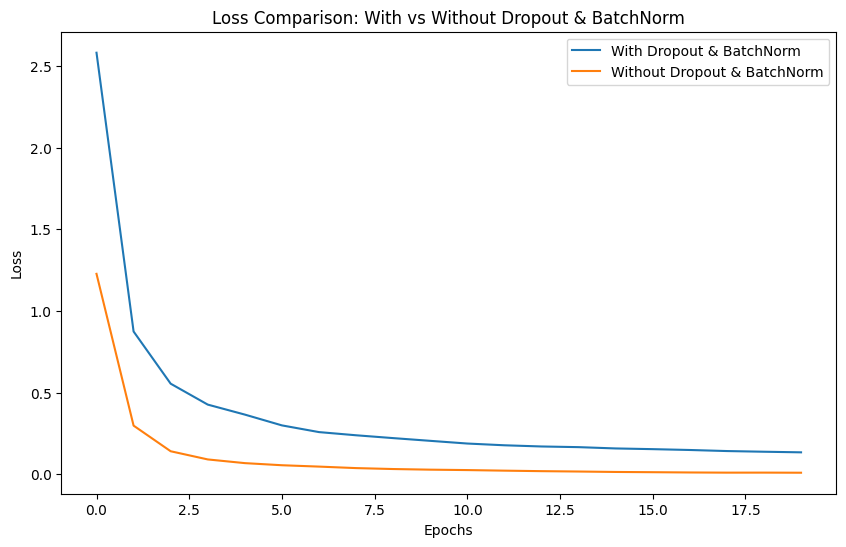

In [ ]:
## 에폭~loss 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history_with_dropout_bn, label='With Dropout & BatchNorm')
plt.plot(loss_history_without_dropout_bn, label='Without Dropout & BatchNorm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison: With vs Without Dropout & BatchNorm')
plt.legend()
plt.show()


- Dropout과 Batch Normalization을 사용한 모델
  - 손실 값이 느리게 감소하지만 더 안정적
  - 과적합이 적을 가능성이 높음
- Dropout과 Batch Normalization을 사용하지 않은 모델
  -  매우 빠르게 학습되고 손실 값이 급격히 줄어듦
  - 학습 데이터에 과적합되었을 가능성이 높음..

In [ ]:
# EOS